In [1]:
#!nvidia-smi

In [2]:
#!pip install sklearn numpy==1.21.6 pandas==1.3.5 matplotlib==3.2.2 spyder==5.1.5 seaborn==0.11.2 pyupbit

In [3]:
import pyupbit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LSTM, Conv1D
from tensorflow.python.keras.losses import Huber
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import numpy as np

In [4]:
MARKETS = pyupbit.get_tickers(fiat="KRW")

df = pd.DataFrame()
for market in MARKETS:
    print(market)
    temp_pd = pyupbit.get_ohlcv(market, count=400, period=0.1, interval="minute5")
    temp_pd['Market'] = market
    df = df.append(temp_pd)
df.to_csv("data.csv")

print(df)

KRW-BTC
KRW-ETH
KRW-NEO
KRW-MTL
KRW-LTC
KRW-XRP
KRW-ETC
KRW-OMG
KRW-SNT
KRW-WAVES
KRW-XEM
KRW-QTUM
KRW-LSK
KRW-STEEM
KRW-XLM
KRW-ARDR
KRW-ARK
KRW-STORJ
KRW-GRS
KRW-REP
KRW-ADA
KRW-SBD
KRW-POWR
KRW-BTG
KRW-ICX
KRW-EOS
KRW-TRX
KRW-SC
KRW-ONT
KRW-ZIL
KRW-POLY
KRW-ZRX
KRW-LOOM
KRW-BCH
KRW-BAT
KRW-IOST
KRW-RFR
KRW-CVC
KRW-IQ
KRW-IOTA
KRW-MFT
KRW-ONG
KRW-GAS
KRW-UPP
KRW-ELF
KRW-KNC
KRW-BSV
KRW-THETA
KRW-QKC
KRW-BTT
KRW-MOC
KRW-ENJ
KRW-TFUEL
KRW-MANA
KRW-ANKR
KRW-AERGO
KRW-ATOM
KRW-TT
KRW-CRE
KRW-MBL
KRW-WAXP
KRW-HBAR
KRW-MED
KRW-MLK
KRW-STPT
KRW-ORBS
KRW-VET
KRW-CHZ
KRW-STMX
KRW-DKA
KRW-HIVE
KRW-KAVA
KRW-AHT
KRW-LINK
KRW-XTZ
KRW-BORA
KRW-JST
KRW-CRO
KRW-TON
KRW-SXP
KRW-HUNT
KRW-PLA
KRW-DOT
KRW-SRM
KRW-MVL
KRW-STRAX
KRW-AQT
KRW-GLM
KRW-SSX
KRW-META
KRW-FCT2
KRW-CBK
KRW-SAND
KRW-HUM
KRW-DOGE
KRW-STRK
KRW-PUNDIX
KRW-FLOW
KRW-DAWN
KRW-AXS
KRW-STX
KRW-XEC
KRW-SOL
KRW-MATIC
KRW-NU
KRW-AAVE
KRW-1INCH
KRW-ALGO
KRW-NEAR
KRW-WEMIX
KRW-AVAX
KRW-T
KRW-CELO
KRW-GMT
                           open        

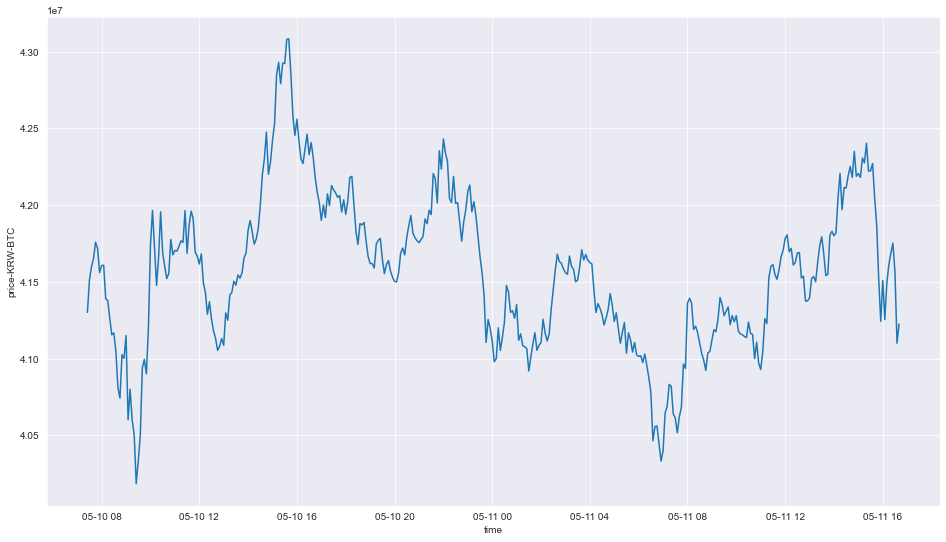

In [5]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=df[df['Market'] == MARKETS[0]]['close'], x=df[df['Market'] == MARKETS[0]].index)
plt.xlabel('time')
plt.ylabel('price-'+MARKETS[0])
plt.show()

In [6]:
scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['open', 'high', 'low', 'close', 'volume', 'value']
# 스케일 후 columns
scaled = scaler.fit_transform(df[scale_cols])

df = pd.DataFrame(scaled, columns=scale_cols)
print(df)

           open      high       low     close        volume     value
0      0.960866  0.960288  0.962299  0.958638  2.241078e-11  0.079858
1      0.958638  0.962955  0.962346  0.963512  1.857431e-11  0.066331
2      0.963350  0.965692  0.967006  0.965532  1.315178e-11  0.047138
3      0.965532  0.966481  0.967845  0.966739  1.230758e-11  0.044148
4      0.966739  0.969102  0.969476  0.969245  1.761891e-11  0.063314
...         ...       ...       ...       ...           ...       ...
45595  0.000048  0.000048  0.000047  0.000047  1.701071e-07  0.029944
45596  0.000047  0.000048  0.000047  0.000047  6.629990e-08  0.011662
45597  0.000047  0.000047  0.000046  0.000046  2.231339e-07  0.038676
45598  0.000046  0.000047  0.000045  0.000045  3.930341e-07  0.066558
45599  0.000045  0.000046  0.000045  0.000046  1.708258e-07  0.028957

[45600 rows x 6 columns]


In [7]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.1, random_state=0, shuffle=False)
print(type(x_test))
print(x_test)

<class 'pandas.core.frame.DataFrame'>
           open      high       low        volume     value
41040  0.002134  0.002136  0.002132  7.921872e-10  0.006265
41041  0.002126  0.002132  0.002130  3.811595e-10  0.003012
41042  0.002131  0.002136  0.002138  6.859511e-10  0.005442
41043  0.002130  0.002145  0.002129  2.243456e-10  0.001777
41044  0.002138  0.002139  0.002134  4.186854e-10  0.003321
...         ...       ...       ...           ...       ...
45595  0.000048  0.000048  0.000047  1.701071e-07  0.029944
45596  0.000047  0.000048  0.000047  6.629990e-08  0.011662
45597  0.000047  0.000047  0.000046  2.231339e-07  0.038676
45598  0.000046  0.000047  0.000045  3.930341e-07  0.066558
45599  0.000045  0.000046  0.000045  1.708258e-07  0.028957

[4560 rows x 5 columns]


C:\Users\frank\AppData\Local\Temp\ipykernel_21564\1081086570.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.1, random_state=0, shuffle=False)


In [8]:
def windowed_dataset(x, y, window_size, batch_size, shuffle):
    # X값 window dataset 구성
    ds_x = tf.data.Dataset.from_tensor_slices(x)
    ds_x = ds_x.window(window_size, shift=1, stride=1, drop_remainder=True)
    ds_x = ds_x.flat_map(lambda t: t.batch(window_size))
    # y값 추가
    ds_y = tf.data.Dataset.from_tensor_slices(y[window_size:])
    ds = tf.data.Dataset.zip((ds_x, ds_y))
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size).prefetch(1)

In [9]:
WINDOW_SIZE=5
BATCH_SIZE=32

In [10]:
train_data = windowed_dataset(x_train, y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(x_test, y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [11]:
model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 5]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1)
])

# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [ ]:
# earlystopping은 35번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=35)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)
                             
history = model.fit(train_data, 
                    validation_data=test_data,
                    epochs=1000,
                    callbacks=[checkpoint, earlystopping])

In [ ]:
print("%.7f" % (float(min(history.history['val_loss']))))
model.load_weights(filename)
pred = model.predict(test_data)
actual = np.asarray(y_test)[WINDOW_SIZE:]
actual = np.reshape(actual, (len(actual), 1))
print(pred.shape)
print(actual.shape)

In [ ]:
# 수집한 데이터 내에서 예측값과 실제값을 출력
plt.figure(figsize=(10,10))
plt.plot(actual, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [ ]:
live_df = pyupbit.get_ohlcv(MARKETS[0], count=400, period=0.1, interval="minute5")

scale_cols = ['open', 'high', 'low', 'close', 'volume', 'price']
scaled = scaler.fit_transform(live_df[scale_cols])
live_scaled_df = pd.DataFrame(scaled, columns=scale_cols)
live_x, live_y = live_scaled_df.drop('close', 1), live_scaled_df['close']
live_data = windowed_dataset(live_x, live_y, WINDOW_SIZE, BATCH_SIZE, False)

pred = model.predict(live_data)

# create empty table with 12 fields
trainPredict_dataset_like = np.zeros(shape=(len(pred), 6) )
# put the predicted values in the right field
trainPredict_dataset_like[:,0] = pred[:,0]
# inverse transform and then select the right field
pred = scaler.inverse_transform(trainPredict_dataset_like)[:,0]

def muzisung_buy(pred_per: float, live_per: float, money: float):
    global array_pred_percents
    array_pred_percents.sort()
    if pred_per > np.mean(array_pred_percents):
        money = money + (money * live_per / 100)
    return money

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(live_df['close'][WINDOW_SIZE:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [ ]:
cnt_minus = 0
cnt_fault = 0
cnt_total = 0
seed_money = 100000000
print(len(live_df['close'][WINDOW_SIZE:]))
print(len(pred))
origin_money = seed_money
origin_percent = (float(live_df['close'][len(live_df['close'])-1]) - float(live_df['close'][WINDOW_SIZE])) / float(live_df['close'][WINDOW_SIZE]) * 100
array_pred_percents = []

for indx in range(len(pred)):
    live_close = float(live_df['close'][indx+WINDOW_SIZE])
    pred_close = float(pred[indx])
    pred_percent = (pred_close - live_close) / live_close * 100
    if pred_percent > 0:
        array_pred_percents.append(pred_percent)

    print("%d - (현재)%.2f -> (10분 뒤)%.2f" % (indx, live_close, pred_close), end='')
    print(" ==> (예측)%.2f%%" % pred_percent, end='')
    
    if indx + WINDOW_SIZE + 1 < len(live_df['close']):
        live_percent = (float(live_df['close'][indx+WINDOW_SIZE+1]) - live_close) / live_close * 100
        print(" | (실제)%.2f%%  | " % live_percent, end='')
        prev_money = seed_money
        next_money = muzisung_buy(pred_percent, live_percent, seed_money)
        print("[%d] -> [%d] == (%d)" % (int(seed_money), int(next_money), int(next_money - seed_money)))
        seed_money = next_money
    else:
        print()
print("(존버시) %d" % (int(origin_money + (origin_money * origin_percent / 100))))
print("(무지성) %d" % (int(seed_money)))
print(cnt_fault)